In [5]:
import keras
from keras import regularizers
import numpy as np
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential, Input
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import LSTM, Bidirectional, Activation
from keras.callbacks import ModelCheckpoint
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

In [28]:
tqdm.monitor_interval = 0
#hyperparamter
DATA_DIR = "../data/"
output_dir = '../data/lstm/'

#data
test_size = 0.1
validation_size = 0.1
random_state = 12345

#Training 
epochs = 8
batch_size = 128

#vector-space embedding
n_dim = 64
n_unique_words = 10000
max_length = 100
pad_type = trunc_type = 'pre' # 'pre' or 'post'
drop_embed = 0.25

#lstm architecture 
n_lstm = 64
drop_lstm = 0.1
kernel_reg_lstm = 0.000014
activity_reg_lstm = 0.00012

#fully connected layer 
n_fc = 64
kernel_reg_fc = 0.000013

#optimizer 
learning_rate = 0.0007


In [20]:
# load the data
data, labels = [],[]
for file in tqdm(os.listdir(DATA_DIR+'pickled/')):
    with open(DATA_DIR+'pickled/'+file,'rb') as f:
        text,label = pickle.load(f)
        data.append(text)
        labels.append(label)

100%|██████████| 51915/51915 [02:13<00:00, 388.04it/s]


In [21]:
len(data)

51915

In [22]:
one_hot = MultiLabelBinarizer()
labels = one_hot.fit_transform(labels)
len(labels[0])

62

In [23]:
data = np.array(data)
labels = np.array(labels)


In [24]:
train_x,test_x, train_y, test_y = train_test_split(data, labels, test_size=test_size, random_state=random_state)

In [25]:
len(train_x), len(train_y), len(test_x), len(test_y)

(46723, 46723, 5192, 5192)

In [26]:
train_y = [x for x in train_y.transpose()]
test_y = [x for x in test_y.transpose()]

In [27]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [29]:
tok_1 = Tokenizer(num_words=n_unique_words)
tok_1.fit_on_texts(train_x)                                
sequences = tok_1.texts_to_sequences(train_x)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)
def RNN_1():
    inputs = Input(name='inputs', shape=[max_length])
    layer = Embedding(n_unique_words, n_dim, input_length=max_length)(inputs)  
    layer = Bidirectional(LSTM(n_lstm, 
                               recurrent_dropout=drop_lstm, 
                               kernel_regularizer=regularizers.l2(kernel_reg_lstm),
                               activity_regularizer=regularizers.l1(activity_reg_lstm))
                         )(layer)
    layer_lst=[]
    sigmoid_lst=[]
    for i in range(len(train_y)):
        fc1 = Dense(n_fc,
                    name='FC_1_'+str(i),
                    kernel_regularizer=regularizers.l2(kernel_reg_fc)
                   )(layer)
        fc2 = Dense(1,
                    name='FC_2_'+str(i),
                    kernel_regularizer=regularizers.l2(kernel_reg_fc)
                   )(fc1)
        sigmoid_lst.append(Activation('sigmoid')(fc2))

    model = Model(inputs=inputs, outputs=sigmoid_lst)
    return model
model = RNN_1()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 64)      640000      inputs[0][0]                     
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128)          66048       embedding_2[0][0]                
__________________________________________________________________________________________________
FC_1_0 (Dense)                  (None, 64)           8256        bidirectional_2[0][0]            
__________________________________________________________________________________________________
FC_1_1 (De

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=learning_rate),metrics=['accuracy'])
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5", save_best_only=True)
history = model.fit(sequences_matrix,
          train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=validation_size, 
          callbacks=[modelcheckpoint])

Train on 42050 samples, validate on 4673 samples
Epoch 1/8
 - 82s - loss: 6.7490 - activation_63_loss: 0.0137 - activation_64_loss: 0.0990 - activation_65_loss: 0.0865 - activation_66_loss: 0.0395 - activation_67_loss: 0.0146 - activation_68_loss: 0.0135 - activation_69_loss: 0.1143 - activation_70_loss: 0.1245 - activation_71_loss: 0.0153 - activation_72_loss: 0.1174 - activation_73_loss: 0.3161 - activation_74_loss: 0.0130 - activation_75_loss: 0.3754 - activation_76_loss: 0.0767 - activation_77_loss: 0.0983 - activation_78_loss: 0.1729 - activation_79_loss: 0.4413 - activation_80_loss: 0.1315 - activation_81_loss: 0.0960 - activation_82_loss: 0.0116 - activation_83_loss: 0.0941 - activation_84_loss: 0.0877 - activation_85_loss: 0.0476 - activation_86_loss: 0.0552 - activation_87_loss: 0.0174 - activation_88_loss: 0.1493 - activation_89_loss: 0.1408 - activation_90_loss: 0.0231 - activation_91_loss: 0.0216 - activation_92_loss: 0.0636 - activation_93_loss: 0.0330 - activation_94_loss

Epoch 3/8


dict_keys(['val_loss', 'val_activation_1_loss', 'val_activation_2_loss', 'val_activation_3_loss', 'val_activation_4_loss', 'val_activation_5_loss', 'val_activation_6_loss', 'val_activation_7_loss', 'val_activation_8_loss', 'val_activation_9_loss', 'val_activation_10_loss', 'val_activation_11_loss', 'val_activation_12_loss', 'val_activation_13_loss', 'val_activation_14_loss', 'val_activation_15_loss', 'val_activation_16_loss', 'val_activation_17_loss', 'val_activation_18_loss', 'val_activation_19_loss', 'val_activation_20_loss', 'val_activation_21_loss', 'val_activation_22_loss', 'val_activation_23_loss', 'val_activation_24_loss', 'val_activation_25_loss', 'val_activation_26_loss', 'val_activation_27_loss', 'val_activation_28_loss', 'val_activation_29_loss', 'val_activation_30_loss', 'val_activation_31_loss', 'val_activation_32_loss', 'val_activation_33_loss', 'val_activation_34_loss', 'val_activation_35_loss', 'val_activation_36_loss', 'val_activation_37_loss', 'val_activation_38_loss'

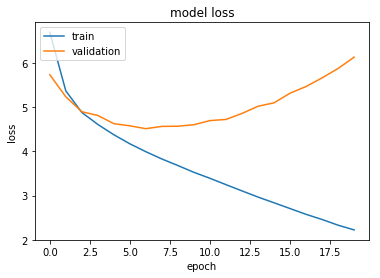

In [18]:
# print(history.history.keys())
# #  "Accuracy"
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()